# Анализ результатов A/B теста по изменению цен, для мобильного dating-приложения.

## Описание:
- На новых пользователях в некоторых странах был проведен A/B-тест. Его суть
заключалась в том, что для тестовой группы удвоили стоимость премиум-подписки при
покупке через платежные системы Google Play и Payment Ninja. Стоимость пробной
подписки не менялась.
- Премиум подписка дает доступ к некоторым важным заблокированным функциям.
Если приобретает премиум-подписку, то ежемесячно с него списывается
фиксированная сумма денег, если он ее не отменит.
- Мы попробовали выяснить, удачен ли эксперимент. 

# Интерактивный план исследования

[01. Предобработка данных](#dataload)

[02. Визуализация](#visual)

[03. Проверка гипотез](#hypotesis)

[04. Выводы](#recap)

## 01. Предобработка данных
<a id='dataload'></a>

Подключим необходимые библиотеки.

In [1]:
# !pip install prettytable

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import prettytable as pt
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats as st
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : '#D9D9D9'}
sns.set(rc={'figure.figsize': (9, 6)})

Загрузим таблицы в формате csv из папки Data.

In [3]:
import os
list_tables_csv = []
list_tables_names = []
for root, dirs, files in os.walk("Data"):  
    for filename in files:
        list_tables_csv.append(filename)
        list_tables_names.append(filename[0:-4])
print("Список файлов:", *list_tables_csv, sep="\n", end="\n\n")
print("Список названий таблиц: ", *list_tables_names, sep="\n")

Список файлов:
payments_CG1.csv
payments_CG2.csv
payments_TG.csv
portrait_CG1.csv
portrait_CG2.csv
portrait_TG.csv

Список названий таблиц: 
payments_CG1
payments_CG2
payments_TG
portrait_CG1
portrait_CG2
portrait_TG


In [4]:
payments_CG1 = pd.read_csv(f"Data/{list_tables_csv[0]}", sep=";")
payments_CG2 = pd.read_csv(f"Data/{list_tables_csv[1]}", sep=";")
payments_TG  = pd.read_csv(f"Data/{list_tables_csv[2]}", sep=";")

In [5]:
portrait_CG1 = pd.read_csv(f"Data/{list_tables_csv[3]}", sep=";")
portrait_CG2 = pd.read_csv(f"Data/{list_tables_csv[4]}", sep=";")
portrait_TG  = pd.read_csv(f"Data/{list_tables_csv[5]}", sep=";")

- TG - тестовая группа с новыми ценами
- CG1, CG2 - контрольные группы со старыми ценами

### 01.01 Первоначальный просмотр данных

Рассмотрим таблицы.

In [6]:
payments_CG1.head()
# payments_CG2.head()
# payments_Tg.head()

,user_id,registration_date,payment_date,revenue,payment_service_id,place,country,product_type
0,891319275.0,05.11.2017 19:57,12.11.2017 21:57,12727.0,147.0,TrialVipPopup,FR,trial
1,892421826.0,14.10.2017 12:46,23.10.2017 12:54,14586.0,147.0,TrialVipPopup,IL,trial
2,891822480.0,26.10.2017 22:27,12.11.2017 20:59,1911.0,19.0,none,IT,coins
3,891367521.0,05.11.2017 2:37,06.11.2017 19:15,1456.0,127.0,sympathy_access,IT,other
4,892207959.0,18.10.2017 18:30,12.11.2017 12:03,1261.0,19.0,EmptyLikes,FR,coins


Таблицы payments - платежи пользователей поштучно:
- user_id            - закодированный уникальный идентификатор пользователя
- registration_date  - дата и время регистрации пользователя
- payment_date       - дата и время платежа
- revenue            - выручка пользователя, нормированная на некоторый коэффициент
- payment_service_id - внутренний идентификатор направления платежа
- place              - место перехода в оплату
- country            - страна
- product_type       - тип продукта

In [7]:
portrait_CG1.head()
# portrait_CG2.head()
# portrait_TG.head()

,user_id,age,attraction_distribution,coins,country,retention_days,sex,user_dating.age_start,user_dating.age_end,view_count,was_special,is_special,total_revenue
0,892319115,25,435,NaN,US,"1,2,3,4,5,6",0,22,32,982,NaN,NaN,0
1,891248523,29,500,NaN,US,"1,2",1,26,32,12,NaN,NaN,0
2,891670932,33,800,NaN,FR,"1,2,3,5,6,8,9,11,13,16",1,30,36,5,NaN,NaN,0
3,891060786,26,0,NaN,AR,"1,2,3,4,5",1,23,29,0,NaN,NaN,0
4,892006554,35,294,NaN,US,"1,2,3,5,6,7,8,9,10,12,15,16,17,19",1,30,40,17,NaN,NaN,0


Таблицы portrait - срез состояний пользователя на текущий момент:
- user_id - закодированный уникальный идентификатор пользователя
- age - возраст пользователя
- attraction_distribution - коэффициент привлекательности пользователя (целое
число от 0 до 1000 = доля поставленных ему лайков лайков от просмотров *
1000)
- coins - число монет (внутренняя валюта)
- country - страна
- retention_days - дни после регистрации, в которые пользователь заходил в
приложение (целое число от 0)
- sex - пол пользователя
- user_dating.age_start - нижняя граница фильтра поиска пользователя
- user_dating.age_end - верхняя граница фильтра поиска пользователя
- view_count - сколько раз пользователя оценивали

Рассмотрим количество объектов, признаков и дубликатов в таблицах.

In [8]:
shapes_index = ["Количество объектов", "Количество признаков", "Количество дубликатов"]
shapes_dict = {f"{list_tables_names[i]}" : 
               (eval(list_tables_names[i]).shape[0], 
                eval(list_tables_names[i]).shape[1], 
                eval(list_tables_names[i]).duplicated().sum())
               for i in range(len(list_tables_names))}

shapes_dict = pd.DataFrame(shapes_dict, index=shapes_index).transpose()
shapes_dict

,Количество объектов,Количество признаков,Количество дубликатов
payments_CG1,1007,8,650
payments_CG2,328,8,5
payments_TG,273,8,7
portrait_CG1,4340,13,0
portrait_CG2,4264,13,0
portrait_TG,4308,13,0


Количество признаков в таблицах по группам совпадает.
Количество объектов в таблице payments_CG1 превышает в 3 раза количество объектов в таблицах payments_CG2, payments_TG, но имеет 650 дубликатов.
Рассмотрим таблицу payments_CG1 на предмет NaN-значений.

### 01.02 Таблицы payments

Рассмотрим таблицы payments.

Удалим дубликаты.

In [9]:
payments_CG1 = payments_CG1.drop_duplicates().reset_index(drop=True)
payments_CG2 = payments_CG2.drop_duplicates().reset_index(drop=True)
payments_TG  = payments_TG.drop_duplicates().reset_index(drop=True)

In [10]:
payments_CG1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             356 non-null    float64
 1   registration_date   356 non-null    object 
 2   payment_date        356 non-null    object 
 3   revenue             356 non-null    float64
 4   payment_service_id  356 non-null    float64
 5   place               356 non-null    object 
 6   country             356 non-null    object 
 7   product_type        356 non-null    object 
dtypes: float64(3), object(5)
memory usage: 22.4+ KB


In [11]:
payments_CG1.isnull().sum().sort_values(ascending=False)

product_type          1
country               1
place                 1
payment_service_id    1
revenue               1
payment_date          1
registration_date     1
user_id               1
dtype: int64

In [12]:
payments_CG1.shape[0]

357

Соберем таблицу пропущенных значений в признаках группы таблиц payments

In [13]:
class Table:
    """Класс для создания таблиц необходимых в проекте."""
    
    def __init__(self, null=False, dtypes=False, describe=False):
        self.null = null
        self.dtypes = dtypes
        self.describe = describe
        
        
    def make_table(self, columns:list, indexes:list, start, stop):
        """"Функция создает таблицу нулевых значений или типов данных
        
        columns : list
            список признаков
        indexes : list
            список индексов
        start, stop : int
            начальное и конечное значение для цикла
        """
        if self.null:
            null_table = {f"{columns[i]}" : eval(columns[i]).isnull().sum()
                          for i in range(start, stop)}
            return pd.DataFrame(null_table, index=indexes)
        elif self.dtypes:
            type_table = {f"{columns[i]}" : eval(columns[i]).dtypes
                          for i in range(start, stop)}
            return pd.DataFrame(type_table, index=indexes)
        
        
    def make_describe_table(self, columns:list, 
                                  indexes:list, 
                                  feature:str, 
                                  start, stop):
        """Функция создает описательную таблицу
        
        columns : list
            список признаков
        indexes : list
            список индексов
        feature : str
            название признака
        start, stop : int
            начальное и конечное значение для цикла
        """
        describe_table = {f"{list_tables_names[i]}" : 
                           eval(list_tables_names[i])[feature].describe()
                           for i in range(start, stop)}
        return pd.DataFrame(describe_table, index=indexes)

Количество пропущенных значений по признакам в таблицах payments:

In [14]:
null_table_payments = Table(null=True).make_table(columns=list_tables_names,
                                                  indexes=payments_CG1.columns,
                                                  start=0,
                                                  stop=3)
null_table_payments

,payments_CG1,payments_CG2,payments_TG
user_id,1,0,0
registration_date,1,0,0
payment_date,1,0,0
revenue,1,0,0
payment_service_id,1,0,0
place,1,0,0
country,1,0,0
product_type,1,0,0


В таблице payments_CG1 по всем признакам совпадает количество NaN-значений в объектах. Удалим пропущенные объекты.

In [15]:
payments_CG1 = payments_CG1.drop(payments_CG1[payments_CG1["user_id"].isnull()].index)

In [16]:
payments_CG1.shape[0]

356

Рассмотрим остальные таблицы группы payments

In [17]:
payments_CG2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323 entries, 0 to 322
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             323 non-null    int64 
 1   registration_date   323 non-null    object
 2   payment_date        323 non-null    object
 3   revenue             323 non-null    int64 
 4   payment_service_id  323 non-null    int64 
 5   place               323 non-null    object
 6   country             323 non-null    object
 7   product_type        323 non-null    object
dtypes: int64(3), object(5)
memory usage: 20.3+ KB


In [18]:
payments_TG.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             266 non-null    int64 
 1   registration_date   266 non-null    object
 2   payment_date        266 non-null    object
 3   revenue             266 non-null    int64 
 4   payment_service_id  266 non-null    int64 
 5   place               266 non-null    object
 6   country             266 non-null    object
 7   product_type        266 non-null    object
dtypes: int64(3), object(5)
memory usage: 16.8+ KB


Соберем таблицу типов признаков по группе таблиц payments.

In [19]:
types_table_payments = Table(dtypes=True).make_table(columns=list_tables_names,
                                                     indexes=payments_CG1.columns,
                                                     start=0,
                                                     stop=3)
types_table_payments

,payments_CG1,payments_CG2,payments_TG
user_id,float64,int64,int64
registration_date,object,object,object
payment_date,object,object,object
revenue,float64,int64,int64
payment_service_id,float64,int64,int64
place,object,object,object
country,object,object,object
product_type,object,object,object


Для таблицы payments_CG1 в сравнении с таблицами payments_CG2, payments_TG различаются типы в следующих столбцах:


In [20]:
error_type_array = payments_CG1.select_dtypes('float64').columns
print(*error_type_array, sep="\n")

user_id
revenue
payment_service_id


Приведем данные столбцы к типу int64.

In [21]:
payments_CG1[error_type_array] = payments_CG1[error_type_array].astype("int64")
payments_CG1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356 entries, 0 to 355
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             356 non-null    int64 
 1   registration_date   356 non-null    object
 2   payment_date        356 non-null    object
 3   revenue             356 non-null    int64 
 4   payment_service_id  356 non-null    int64 
 5   place               356 non-null    object
 6   country             356 non-null    object
 7   product_type        356 non-null    object
dtypes: int64(3), object(5)
memory usage: 25.0+ KB


Столбцы registration_date, payment_date содержат даты, но в таблицах payments определены как тип object. Приведем данные столбцы к типу datetime.

In [22]:
date_array = ["registration_date", "payment_date"]

In [23]:
def cast_to_datetime(df, column):
    """Функция cast_to_datetime, 
    корректно преобразует данные в столбцах с датами.
    
    df : pd.DataFrame
        DataFrame в котором производится преобразование.
    column : str
        Название столбца который необходимо преобразовать.
    """
    df[column] = pd.to_datetime(df[column].str.replace(" ", "T"), 
                                format="%d.%m.%YT%H:%M")

In [24]:
for column in date_array:
    for i in range(0, 3):
        cast_to_datetime(eval(list_tables_names[i]), column)

In [25]:
payments_CG1.head()

,user_id,registration_date,payment_date,revenue,payment_service_id,place,country,product_type
0,891319275,2017-11-05 19:57:00,2017-11-12 21:57:00,12727,147,TrialVipPopup,FR,trial
1,892421826,2017-10-14 12:46:00,2017-10-23 12:54:00,14586,147,TrialVipPopup,IL,trial
2,891822480,2017-10-26 22:27:00,2017-11-12 20:59:00,1911,19,none,IT,coins
3,891367521,2017-11-05 02:37:00,2017-11-06 19:15:00,1456,127,sympathy_access,IT,other
4,892207959,2017-10-18 18:30:00,2017-11-12 12:03:00,1261,19,EmptyLikes,FR,coins


### 01.03 Таблицы portrait

In [26]:
portrait_CG1.head()

,user_id,age,attraction_distribution,coins,country,retention_days,sex,user_dating.age_start,user_dating.age_end,view_count,was_special,is_special,total_revenue
0,892319115,25,435,NaN,US,"1,2,3,4,5,6",0,22,32,982,NaN,NaN,0
1,891248523,29,500,NaN,US,"1,2",1,26,32,12,NaN,NaN,0
2,891670932,33,800,NaN,FR,"1,2,3,5,6,8,9,11,13,16",1,30,36,5,NaN,NaN,0
3,891060786,26,0,NaN,AR,"1,2,3,4,5",1,23,29,0,NaN,NaN,0
4,892006554,35,294,NaN,US,"1,2,3,5,6,7,8,9,10,12,15,16,17,19",1,30,40,17,NaN,NaN,0


In [27]:
portrait_CG1.info()
#portrait_CG2.info()
#portrait_TG.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   user_id                  4340 non-null   int64  
 1   age                      4340 non-null   int64  
 2   attraction_distribution  4340 non-null   int64  
 3   coins                    60 non-null     float64
 4   country                  4340 non-null   object 
 5   retention_days           3016 non-null   object 
 6   sex                      4340 non-null   int64  
 7   user_dating.age_start    4340 non-null   int64  
 8   user_dating.age_end      4340 non-null   int64  
 9   view_count               4340 non-null   int64  
 10  was_special              436 non-null    float64
 11  is_special               192 non-null    float64
 12  total_revenue            4340 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 440.9+ KB


Соберем таблицу с пропущенными значениями

In [28]:
null_table_portrait = Table(null=True).make_table(columns=list_tables_names,
                                                  indexes=portrait_CG1.columns,
                                                  start=3,
                                                  stop=len(list_tables_names))
null_table_portrait

,portrait_CG1,portrait_CG2,portrait_TG
user_id,0,0,0
age,0,0,0
attraction_distribution,0,0,0
coins,4280,4203,4259
country,0,0,0
retention_days,1324,1364,1330
sex,0,0,0
user_dating.age_start,0,0,0
user_dating.age_end,0,0,0
view_count,0,0,0


Согласно описанию таблиц заменим пропущенные значения на 0, без ущерба для качества данных.

In [29]:
null_column_array = null_table_portrait.index[null_table_portrait['portrait_CG1'] != 0].tolist()

In [30]:
for column in null_column_array:
    for i in range(3, len(list_tables_names)):
        eval(list_tables_names[i])[column].fillna(0, inplace=True)

In [31]:
# portrait_CG1.info()
# portrait_CG2.info()
# portrait_TG.info()

Рассмотрим типы признаков в таблицах portrait

In [32]:
types_table_portrait = Table(dtypes=True).make_table(columns=list_tables_names,
                                                     indexes=portrait_CG1.columns,
                                                     start=3,
                                                     stop=len(list_tables_names))
types_table_portrait

,portrait_CG1,portrait_CG2,portrait_TG
user_id,int64,int64,int64
age,int64,int64,int64
attraction_distribution,int64,int64,int64
coins,float64,float64,float64
country,object,object,object
retention_days,object,object,object
sex,int64,int64,int64
user_dating.age_start,int64,int64,int64
user_dating.age_end,int64,int64,int64
view_count,int64,int64,int64


В группе таблиц portrait типы соответственно признакам верны.

Приведем столбцы coins, was_special, is_special к типу int64.

In [33]:
change_type_array_portrait = portrait_CG1.select_dtypes('float64').columns
portrait_CG1[change_type_array_portrait] = portrait_CG1[change_type_array_portrait].astype("int64")
portrait_CG2[change_type_array_portrait] = portrait_CG2[change_type_array_portrait].astype("int64")
portrait_TG[change_type_array_portrait] = portrait_TG[change_type_array_portrait].astype("int64")

In [34]:
portrait_TG.head()

,user_id,age,attraction_distribution,coins,country,retention_days,sex,user_dating.age_start,user_dating.age_end,view_count,was_special,is_special,total_revenue
0,892309896,27,685,0,US,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,0,0,0
1,892044516,27,0,0,DE,0,1,24,30,0,0,0,0
2,892185708,45,44,0,IL,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,0,0,0
3,892130292,32,0,0,US,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,0,0,0
4,891406035,27,1000,0,FR,0,1,24,30,1,1,0,0


Добавим признак len_retention считающий количество дней возвратов пользователей.

In [35]:
portrait_CG1["len_retention"] = portrait_CG1["retention_days"]\
                                                            .str.split(",")\
                                                            .str.len()\
                                                            .fillna(0)\
                                                            .astype("int64")
portrait_CG2["len_retention"] = portrait_CG1["retention_days"]\
                                                            .str.split(",")\
                                                            .str.len()\
                                                            .fillna(0)\
                                                            .astype("int64")
portrait_TG["len_retention"] = portrait_TG["retention_days"]\
                                                            .str.split(",")\
                                                            .str.len()\
                                                            .fillna(0)\
                                                            .astype("int64")

## 02. Визуализация признаков
<a id='visual'></a>

Общее количество пользователей:

In [36]:
total_user_CG1 = portrait_CG1["user_id"].unique().shape[0]
total_user_CG2 = portrait_CG2["user_id"].unique().shape[0]
total_user_TG  = portrait_TG["user_id"].unique().shape[0]
print(total_user_CG1, total_user_CG2, total_user_TG, sep="\n")

4340
4264
4308


### 02.01 Выручка

Рассмотрим выручку.

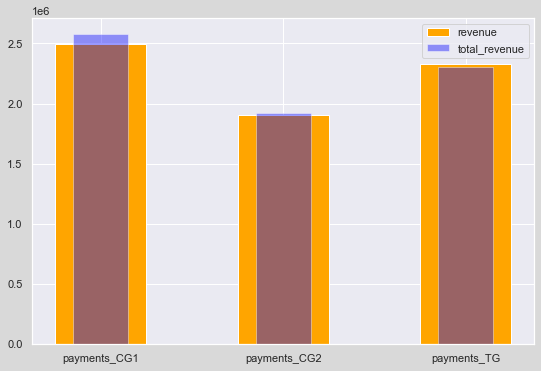

In [37]:
x = ["revenue", "total_revenue"]
revenue = [eval(list_tables_names[i])["revenue"].sum() for i in range(3)]
total_revenue = [eval(list_tables_names[i])["total_revenue"].sum() for i in range(3, 6)]
fig, ax = plt.subplots()
ax.bar(list_tables_names[:3], revenue, color="orange", width=0.5, label="revenue")
ax.bar(list_tables_names[:3], total_revenue, color="blue", width=0.3, alpha=0.4, label="total_revenue")
plt.legend(loc='upper right')
plt.title("")
plt.show()

Общая выручка в тестовой группе меньше относительно контрольной группы 1, но больше относительно контрольной группы 2.

Средние выручка и общая выручка.

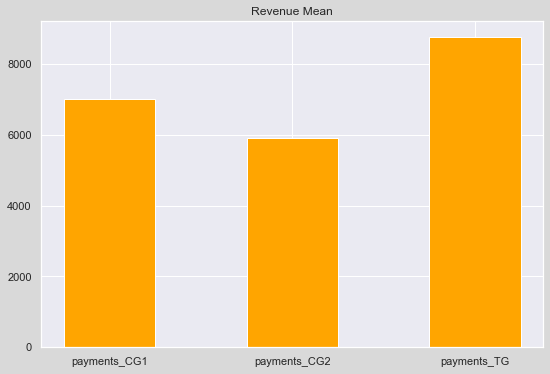

In [38]:
revenue_mean = [eval(list_tables_names[i])["revenue"].mean() for i in range(3)]
plt.bar(list_tables_names[:3], revenue_mean, color="orange", width=0.5, label="revenue")
plt.title("Revenue Mean")
plt.show()

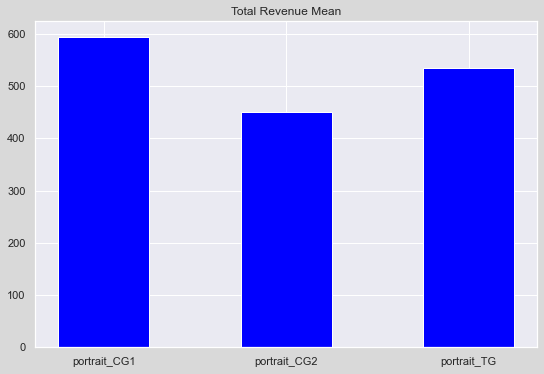

In [39]:
total_revenue_mean = [eval(list_tables_names[i])["total_revenue"].mean() for i in range(3, 6)]
plt.bar(list_tables_names[3:], total_revenue_mean, color="blue", width=0.5, label="revenue")
plt.title("Total Revenue Mean")
plt.show()

Построим графики boxplot для revenue

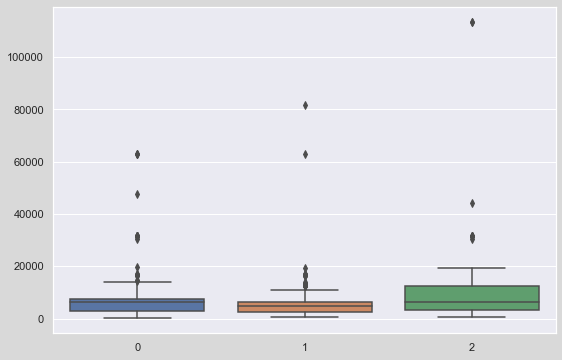

In [40]:
revenue_box = [eval(list_tables_names[i])["revenue"] for i in range(0, 3)]
sns.boxplot(data=revenue_box)

Для лучшего масштаба выберем значения меньше 20000:

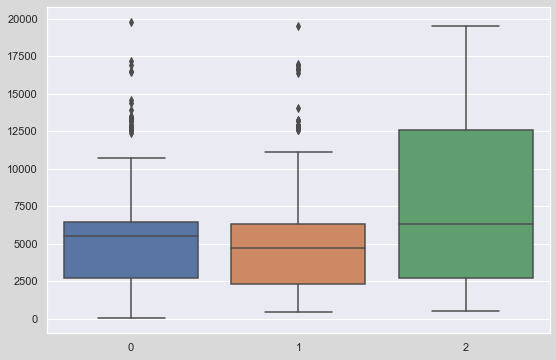

In [41]:
revenue_box_scale = [eval(list_tables_names[i])["revenue"]\
               .loc[lambda x: x < 2e4] for i in range(0, 3)]
sns.boxplot(data=revenue_box_scale)

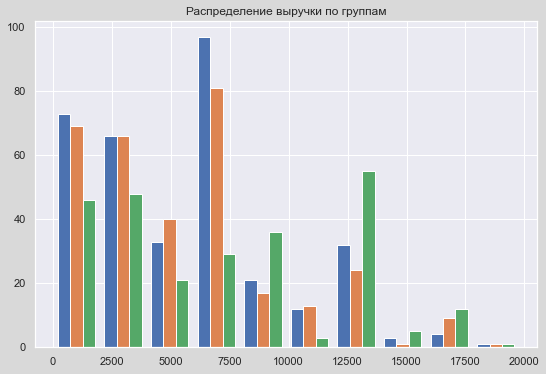

In [42]:
plt.hist(revenue_box_scale)
plt.title("Распределение выручки по группам")
plt.show()

Возможно средняя выручка возросла на тестовой выборке. Проверим данную гипотезу ниже.

График boxplot для total_revenue

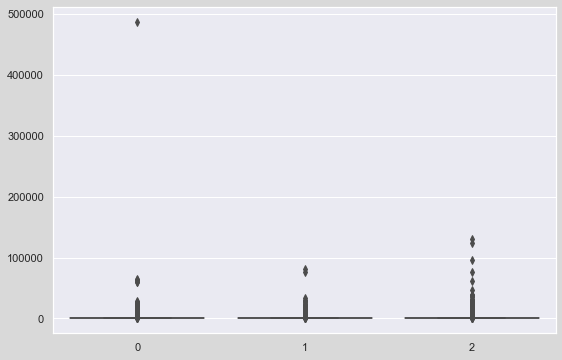

In [43]:
total_revenue_box = [eval(list_tables_names[i])["total_revenue"] for i in range(3, 6)]
sns.boxplot(data=total_revenue_box)

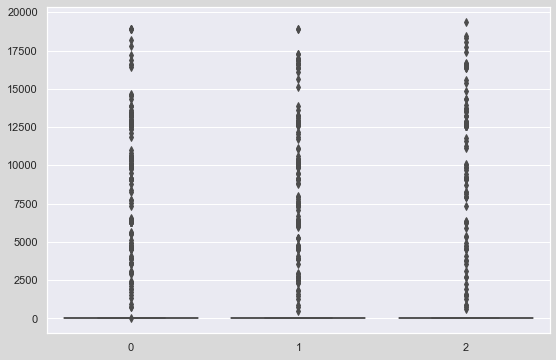

In [44]:
total_revenue_box = [eval(list_tables_names[i])["total_revenue"]\
                     .loc[lambda x: x < 2e4] for i in range(3, 6)]
sns.boxplot(data=total_revenue_box)

Как видно из графика большинство пользователей имеют значение 0 в признаке total_revenue.

Топ-10 стран по общей выручке:

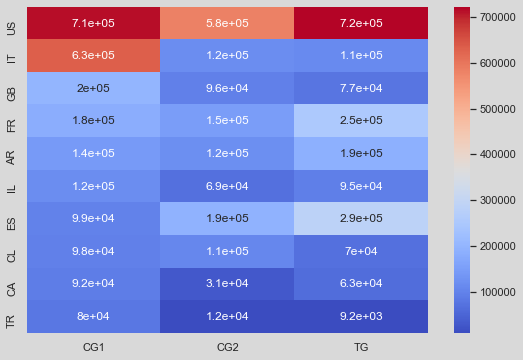

In [45]:
table_country = {"CG1" : portrait_CG1.groupby("country")["total_revenue"].sum(),
                 "CG2" : portrait_CG2.groupby("country")["total_revenue"].sum(),
                 "TG"  : portrait_TG.groupby("country")["total_revenue"].sum()}
table_country = pd.DataFrame(table_country).fillna(0).astype("int64")
# table_country.sort_values("CG1", ascending=False).head(10)
sns.heatmap(table_country.sort_values("CG1", ascending=False).head(10), 
            annot=True, 
            cmap= 'coolwarm')

Из графика видно что общая выручка снизилась для стран из топ-3:

- IT - Италия
- GB - Великобритания

### 02.02 Возраст

Рассмотрим пользователей у которых есть премиум статус по возрасту:

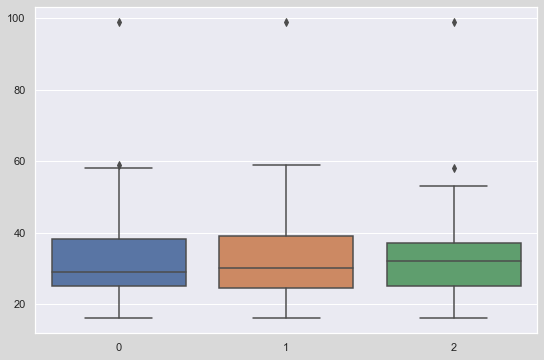

In [46]:
is_special_CG1_age = portrait_CG1[portrait_CG1["is_special"] == 1]["age"]
is_special_CG2_age = portrait_CG2[portrait_CG2["is_special"] == 1]["age"]
is_special_TG_age = portrait_TG[portrait_TG["is_special"] == 1]["age"]

age_box = [is_special_CG1_age, is_special_CG2_age, is_special_TG_age]
sns.boxplot(data=age_box)

Отмасштабируем по пользователям которым меньше 60 лет:

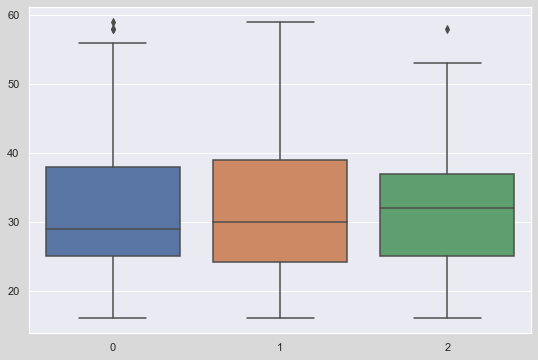

In [47]:
age_box_scale = [age.loc[lambda x: x < 60] for age in age_box]
sns.boxplot(data=age_box_scale)

На тестовой группе возможно изменение среднего возраста.

### 02.03 Монеты

Рассмотрим пользователей по количеству монет:

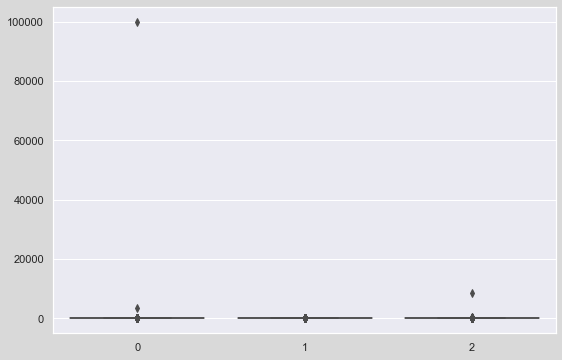

In [48]:
coins_box = [eval(list_tables_names[i])["coins"] for i in range(3, 6)]
sns.boxplot(data=coins_box)

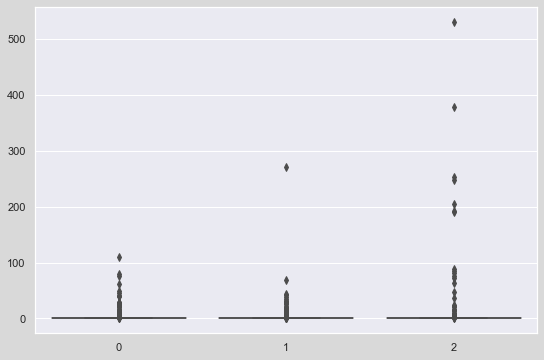

In [49]:
coins_box = [eval(list_tables_names[i])["coins"].loc[lambda x: x < 1000] for i in range(3, 6)]
sns.boxplot(data=coins_box)

Большинство пользователей не имеют монет на момент А/Б теста.

### 02.04 Типы продуктов

Расспотрим типы продуктов по группам:

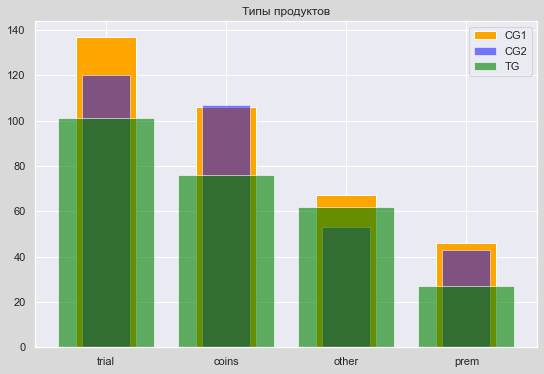

In [50]:
product_type_CG1 = payments_CG1["product_type"].value_counts()
product_type_CG2 = payments_CG2["product_type"].value_counts()
product_type_TG  = payments_TG["product_type"].value_counts()

x = payments_CG1["product_type"].unique()
fig, ax = plt.subplots()
ax.bar(x, product_type_CG1, color="orange", width=0.5, label="CG1")
ax.bar(x, product_type_CG2, color="blue", width=0.4, alpha=0.5, label="CG2")
ax.bar(x, product_type_TG, color="green", alpha=0.6, label="TG")
plt.legend(loc='upper right')
plt.title("Типы продуктов")
plt.show()

Снижение количества оплаченных продуктов в тестовой группе возможно связано с меньшим числом пользователей выбранных в тестовую группу. Посмотрим в процентном соотношении.

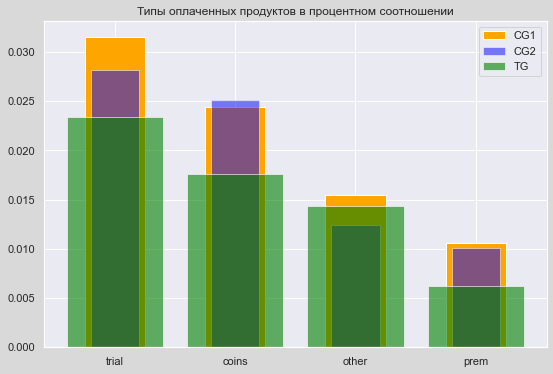

In [51]:
x = payments_CG1["product_type"].unique()
fig, ax = plt.subplots()
ax.bar(x, product_type_CG1 / total_user_CG1, color="orange", width=0.5, label="CG1")
ax.bar(x, product_type_CG2 / total_user_CG2, color="blue", width=0.4, alpha=0.5, label="CG2")
ax.bar(x, product_type_TG  / total_user_TG, color="green", alpha=0.6, label="TG")
plt.legend(loc='upper right')
plt.title("Типы оплаченных продуктов в процентном соотношении")
plt.show()

Предположение подтвердилось.

### 02.05 Премиум статус

Рассмотрим количество пользователей у которых есть премиум статус на момент А/Б теста.

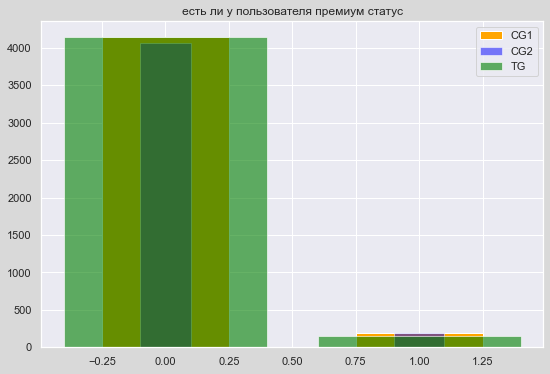

In [52]:
is_special_CG1 = portrait_CG1["is_special"].value_counts()
is_special_CG2 = portrait_CG2["is_special"].value_counts()
is_special_TG = portrait_TG["is_special"].value_counts()

x = portrait_CG1["is_special"].unique()
fig, ax = plt.subplots()
ax.bar(x, is_special_CG1, color="orange", width=0.5, label="CG1")
ax.bar(x, is_special_CG2, color="blue", width=0.2, alpha=0.5, label="CG2")
ax.bar(x, is_special_TG, color="green", alpha=0.6, label="TG")
plt.legend(loc='upper right')
plt.title("есть ли у пользователя премиум статус")
plt.show()

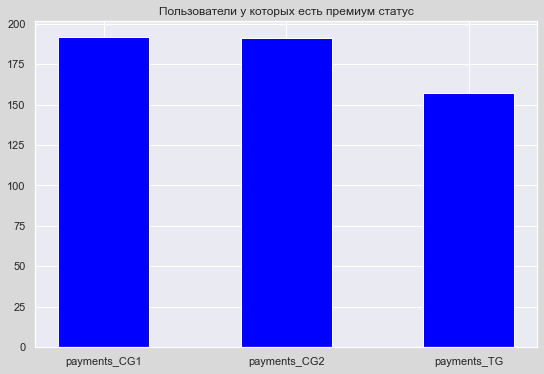

In [53]:
x = list_tables_names[0:3]
y = [is_special_CG1[1], 
     is_special_CG2[1], 
     is_special_TG[1]]

plt.bar(x, y, color="blue", width=0.5)
plt.title("Пользователи у которых есть премиум статус")
plt.show()

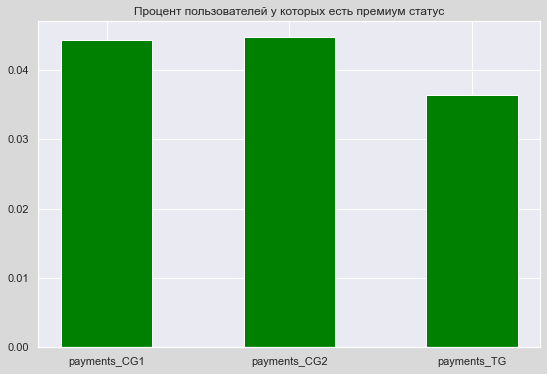

In [54]:
x = list_tables_names[0:3]
y = [is_special_CG1[1] / total_user_CG1,
     is_special_CG2[1] / total_user_CG2,
     is_special_TG[1]  / total_user_TG]

plt.bar(x, y, color="green", width=0.5)
plt.title("Процент пользователей у которых есть премиум статус")
plt.show()

Процент пользователей имеющих премиум статус снижается на тестовой выборке. Возможно это связано с новой ценой на премиус статус

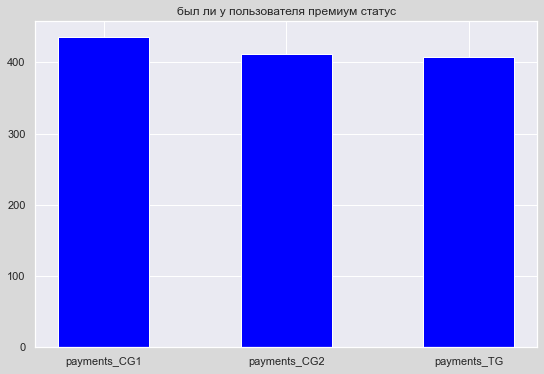

In [55]:
x = list_tables_names[0:3]
y1 = [portrait_CG1["was_special"].value_counts()[1], 
      portrait_CG2["was_special"].value_counts()[1], 
      portrait_TG["was_special"].value_counts()[1]]


plt.bar(x, y1, color="blue", width=0.5)
plt.title("был ли у пользователя премиум статус")
plt.show()

### 02.06 Retention Days

Посмотрим на распределение возвратов пользователей по количеству дней после регистрации.

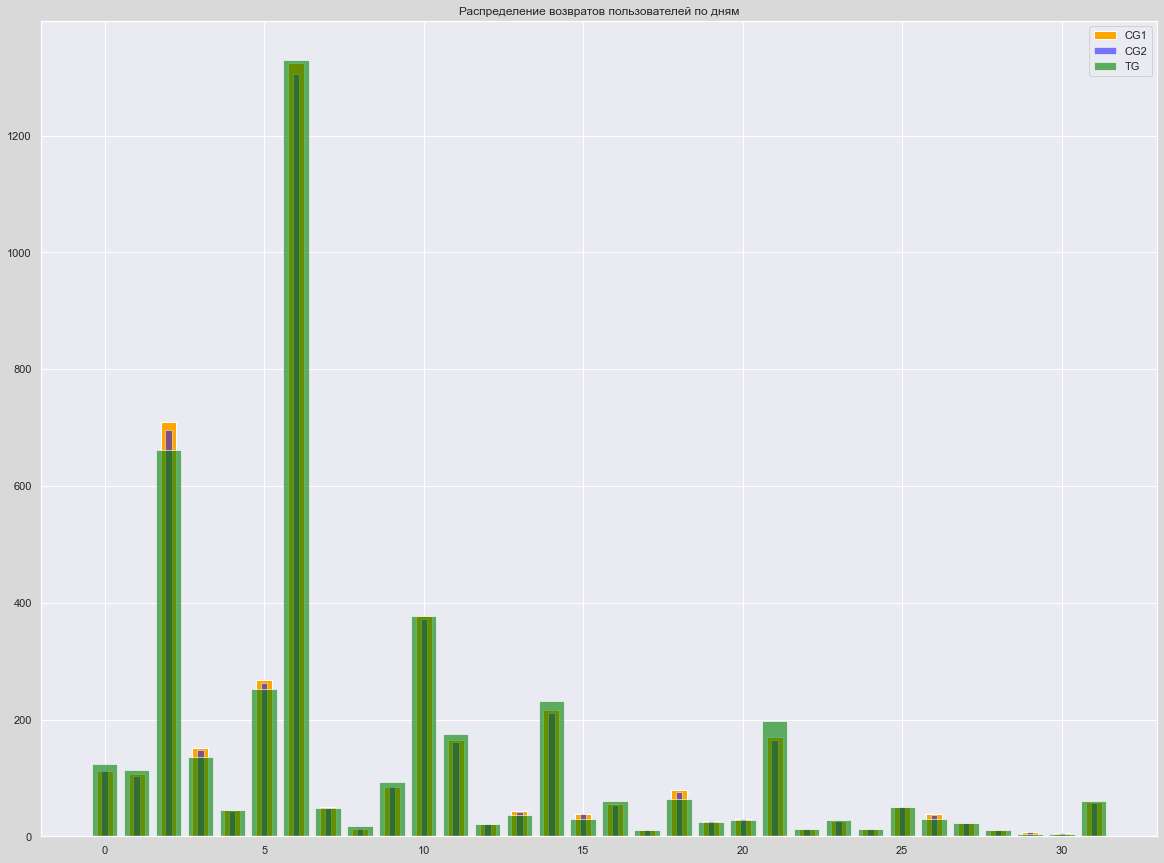

In [56]:
x = portrait_CG1["len_retention"].unique()
y1 = portrait_CG1["len_retention"].value_counts()
y2 = portrait_CG2["len_retention"].value_counts()
y3 = portrait_TG["len_retention"].value_counts()
fig, ax = plt.subplots()
ax.bar(x, y1, color="orange", width=0.5, label="CG1")
ax.bar(x, y2, color="blue", width=0.2, alpha=0.5, label="CG2")
ax.bar(x, y3, color="green", alpha=0.6, label="TG")
fig.set_figwidth(20)
fig.set_figheight(15) 
plt.legend(loc='upper right')
plt.title("Распределение возвратов пользователей по дням")
plt.show()

Наибольшее число пользователей возвращается шесть раз после регистрации.

Соотношение количества дней, в которых пользователи возвращаются, к общему числу пользователей.

In [57]:
user_retention_CG1 = portrait_CG1[portrait_CG1["len_retention"] != 0].shape[0]
user_retention_CG2 = portrait_CG2[portrait_CG2["len_retention"] != 0].shape[0]
user_retention_TG  = portrait_TG[portrait_TG["len_retention"] != 0].shape[0]

user_retention_CG1_premium = portrait_CG1[(portrait_CG1["len_retention"] != 0)\
                                          & (portrait_CG1["is_special"] == 1)].shape[0]
user_retention_CG2_premium = portrait_CG2[(portrait_CG2["len_retention"] != 0)\
                                          & (portrait_CG2["is_special"] == 1)].shape[0]
user_retention_TG_premium   = portrait_TG[(portrait_TG["len_retention"] != 0)\
                                          & (portrait_TG["is_special"] == 1)].shape[0]

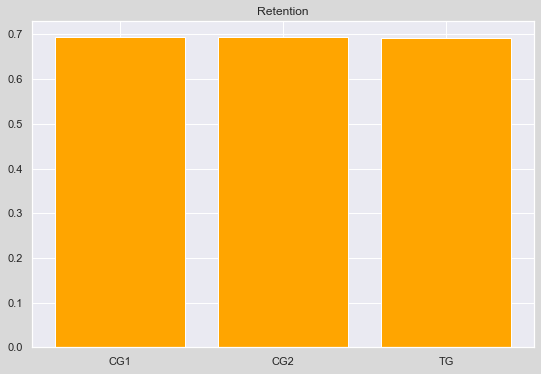

In [58]:
x = ["CG1", "CG2", "TG"]
y1 = [user_retention_CG1 / total_user_CG1, 
     user_retention_CG2 / total_user_CG2, 
     user_retention_TG / total_user_TG]

plt.bar(x, y1, color="orange")
plt.title("Retention")
plt.show()

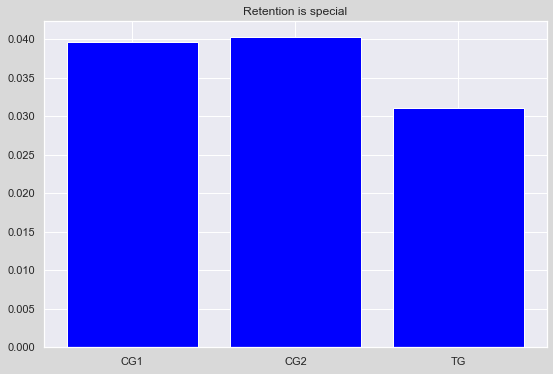

In [59]:
x = ["CG1", "CG2", "TG"]
y = [user_retention_CG1_premium / total_user_CG1,
      user_retention_CG1_premium / total_user_CG2,
      user_retention_TG_premium / total_user_TG]
plt.bar(x, y, color="blue")
plt.title("Retention is special")
plt.show()

В соотношении количество дней в которых пользователи возвращаются к общему числу пользователй после регистрации на тестовой группе не изменилось.

## 03. Проверка гипотез
<a id='hypotesis'></a>

### 03.01. Таблицы payments

### Выручка

Рассмотрим меры центральной тенденции и изменчивости признака revenue в таблицах payments.

In [60]:
desc_index_1 = payments_CG1.describe().index
describe_table_revenue = Table(describe=True)\
    .make_describe_table(columns=list_tables_names,
                         indexes=desc_index_1,
                         feature="revenue",
                         start=0,
                         stop=3)
describe_table_revenue

,payments_CG1,payments_CG2,payments_TG
count,356.000000,323.000000,266.000000
mean,7007.876404,5907.111455,8767.766917
std,7985.995094,6615.180325,11216.235341
min,26.000000,481.000000,533.000000
25%,2804.750000,2340.000000,3129.750000
50%,6292.000000,4719.000000,6363.500000
75%,7312.500000,6350.500000,12597.000000
max,63037.000000,81796.000000,113477.000000


Создадим функции для проверки статистической значимости гипотез:
- t-test Стьюдента
- u-test Манна-Уитни

In [61]:
def ttestStudent(cg, tg, alpha):
    """t-tест Стьюдента для независимых выборок
    cg : pd.Series
        control group - контрольная группа пользователей
    tg : pd.Series
        test group - тестовая группа пользователей
    alpha : int
        пороговое значение для статистической значимости
    """    
    # средние
    mean_cg, mean_tg = cg.mean(), tg.mean()    
    # стандартные ошибки
    # # функция st.sem идентична cg.std() / (len(cg)**0.5)
    se_cg, se_tg = st.sem(cg), st.sem(tg)    
    # стандартная ошибка разности средних 
    sed = (se_cg**2 + se_tg**2)**0.5    
    # число степеней свободы
    df = len(cg) + len(tg) - 2    
    # критическое значение 
    cv = st.t.ppf(1 - alpha, df)
    # в зависимости от равенства дисперсий выборок 
    # рассчитаем t-критерий и p-value:
    # t критерий
    t_stat = 0
    p_value = 0    
    if cg.var() == tg.var():
        t_stat = (mean_cg - mean_tg) / sed
        p_value = (1 - st.t.cdf(abs(t_stat), df)) * 2
    else:
        # если дисперсии не равны для независимых выборок применяется
        # t-критерий Уэлча
        t_stat  = st.ttest_ind(cg, tg, equal_var=False)[0]
        p_value = st.ttest_ind(cg, tg, equal_var=False)[1]
        
    # вывод
    answer = str()
    if p_value < alpha: answer = "Отвергаем нулевую гипотезу"
    else: answer = "Не получилось отвергнуть нулевую гипотезу"

    # результирующий ссловарь
    result = pd.Series({"t_stat" : t_stat,
                        "df" : df,
                        "cv" : cv,
                        "p_value" : p_value,
                        "answer" : answer})

    return result

In [62]:
def utestMannWhitneyu(cg, tg, alpha):
    """U-tест Манна-Уитни для независимых выборок
    cg : pd.Series
        control group - контрольная группа пользователей
    tg : pd.Series
        test group - тестовая группа пользователей
    alpha : int
        пороговое значение для статистической значимости
    """
    
    u_stat = 0
    p_value = 0
    
    u_stat = st.mannwhitneyu(cg, tg)[0]
    p_value = st.mannwhitneyu(cg, tg)[1]
    # вывод
    answer = str()
    if p_value < alpha: answer = "Отвергаем нулевую гипотезу"
    else: answer = "Не получилось отвергнуть нулевую гипотезу"
    
    result = pd.Series({"u_stat" : u_stat,
                        "p_value" : p_value,
                        "answer" : answer})
    return result    

#### Гипотеза о среднем по выручке

Выдвинем гипотезы:

- H0 - среднее значение выручки между группами не изменилось (нулевая гипотеза)
- H1 - среднее значение выручки тестовой группы выросло (альтернативная гипотеза)

Проверим статистическую значимость альтернативной гипотезы с помощью t-test Стъюдента

In [63]:
revenue_CG1 = payments_CG1["revenue"]
revenue_CG2 = payments_CG2["revenue"]
revenue_TG = payments_TG["revenue"]
alpha = 0.05

ttest_CG1_revenue = ttestStudent(revenue_CG1, revenue_TG, alpha)
ttest_CG2_revenue = ttestStudent(revenue_CG2, revenue_TG, alpha)
ttest_table_revenue = pd.DataFrame(ttest_CG1_revenue, 
                                   columns=["ttest_CG1_revenue"], 
                                   index=ttest_CG1_revenue.keys())
ttest_table_revenue["ttest_CG2_revenue"] = ttest_CG2_revenue
ttest_table_revenue

,ttest_CG1_revenue,ttest_CG2_revenue
t_stat,-2.17937,-3.66742
df,620,587
cv,1.64732,1.64745
p_value,0.0298164,0.000277209
answer,Отвергаем нулевую гипотезу,Отвергаем нулевую гипотезу


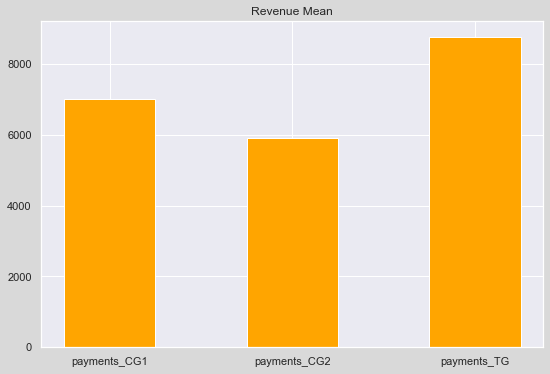

In [64]:
revenue_mean = [eval(list_tables_names[i])["revenue"].mean() for i in range(3)]
plt.bar(list_tables_names[:3], revenue_mean, color="orange", width=0.5, label="revenue")
plt.title("Revenue Mean")
plt.show()

Действительно, исходя из t-test, табличных значений и графика принимаем альтернативную гипотезу, что средняя выручка по тестовой группе выпросла относительно контрольных групп.

#### Гипотеза о распределении выручки

Выдвинем гипотезы:

- H0 - распределение выручки между группами не изменилось (нулевая гипотеза)
- H1 - распределение выручки для тестовой группы изменилось (альтернативная гипотеза)

In [65]:
utest_CG1_revenue = utestMannWhitneyu(revenue_CG1, revenue_TG, alpha)
utest_CG2_revenue = utestMannWhitneyu(revenue_CG2, revenue_TG, alpha)
utest_table_revenue = pd.DataFrame(utest_CG1_revenue, 
                                   columns=["utest_CG1_revenue"], 
                                   index=utest_CG1_revenue.keys())
utest_table_revenue["utest_CG2_revenue"] = utest_CG2_revenue
utest_table_revenue

,utest_CG1_revenue,utest_CG2_revenue
u_stat,40815,34220
p_value,0.00159796,1.04694e-05
answer,Отвергаем нулевую гипотезу,Отвергаем нулевую гипотезу


Исходя из u-test, принимаем альтернативную гипотезу.

### 03.02 Таблицы portrait

Рассмотрим меры центральной тенденции и изменчивости признаков в таблицах portrait.

Возьмем признаки age, len_retention, total_revenue

In [66]:
desc_index_2 = portrait_CG1.describe().index
portrait_desc_features = ["age", "len_retention", "total_revenue"]
for feature in portrait_desc_features:
    
        tmp_table = Table(describe=True)\
            .make_describe_table(columns=list_tables_names,
                                 indexes=desc_index_2,
                                 feature=feature,
                                 start=3,
                                 stop=len(list_tables_names))
        
        x = pt.PrettyTable()
        x.add_column("#", desc_index_2)
        x.add_column("CG1", tmp_table.iloc[:, 0].round(2))
        x.add_column("CG2", tmp_table.iloc[:, 1].round(2))
        x.add_column("TG",  tmp_table.iloc[:, 2].round(2))
        x.align = "l"

        print("\t"+feature, x, sep="\n", end="\n\n")

	age
+-------+--------+--------+--------+
| #     | CG1    | CG2    | TG     |
+-------+--------+--------+--------+
| count | 4340.0 | 4264.0 | 4308.0 |
| mean  | 32.1   | 32.05  | 31.89  |
| std   | 10.26  | 10.17  | 10.25  |
| min   | 16.0   | 16.0   | 16.0   |
| 25%   | 24.0   | 25.0   | 25.0   |
| 50%   | 30.0   | 30.0   | 30.0   |
| 75%   | 38.0   | 38.0   | 38.0   |
| max   | 99.0   | 99.0   | 99.0   |
+-------+--------+--------+--------+

	len_retention
+-------+--------+--------+--------+
| #     | CG1    | CG2    | TG     |
+-------+--------+--------+--------+
| count | 4340.0 | 4264.0 | 4308.0 |
| mean  | 4.64   | 4.64   | 4.59   |
| std   | 6.31   | 6.33   | 6.19   |
| min   | 0.0    | 0.0    | 0.0    |
| 25%   | 0.0    | 0.0    | 0.0    |
| 50%   | 2.0    | 2.0    | 2.0    |
| 75%   | 7.0    | 7.0    | 7.0    |
| max   | 31.0   | 31.0   | 31.0   |
+-------+--------+--------+--------+

	total_revenue
+-------+----------+---------+----------+
| #     | CG1      | CG2     | TG

### Возраст

#### Гипотеза о среднем возрасте

Выдвенем гипотезу:
- H0 - среднее по возрасту пользователей у которых есть премиум статус не изменилось (нулевая гипотеза)
- H1 - среднее по возрасту пользователей у которых есть премиум статус изменилось (альтернативная гипотеза)

In [67]:
age_CG1 = is_special_CG1_age
age_CG2 = is_special_CG2_age
age_TG  = is_special_TG_age
alpha = 0.05

ttest_CG1_age = ttestStudent(age_CG1, age_TG, alpha)
ttest_CG2_age = ttestStudent(age_CG2, age_TG, alpha)
ttest_table_age = pd.DataFrame(ttest_CG1_age, columns=["ttest_CG1_age"], index=ttest_CG1_age.keys())
ttest_table_age["ttest_CG2_age"] = ttest_CG2_age
ttest_table_age

,ttest_CG1_age,ttest_CG2_age
t_stat,-0.106433,0.0982343
df,347,346
cv,1.64926,1.64927
p_value,0.915301,0.921804
answer,Не получилось отвергнуть нулевую гипотезу,Не получилось отвергнуть нулевую гипотезу


Согласно t-test, принимаем нулевую гипотезу.

#### Гипотеза о распределении возраста

Выдвенем гипотезу:
- H0 - распределение возраста не изменилось (нулевая гипотеза)
- H1 - распределение возраста изменилось (альтернативная гипотеза)

In [68]:
utest_CG1_age = utestMannWhitneyu(age_CG1, age_TG, alpha)
utest_CG2_age = utestMannWhitneyu(age_CG2, age_TG, alpha)
utest_table_age = pd.DataFrame(utest_CG1_age, 
                               columns=["utest_CG1_age"], 
                               index=utest_CG1_age.keys())
utest_table_age["utest_CG2_age"] = utest_CG2_age
utest_table_age

,utest_CG1_age,utest_CG2_age
u_stat,14271.5,14685
p_value,0.196595,0.370695
answer,Не получилось отвергнуть нулевую гипотезу,Не получилось отвергнуть нулевую гипотезу


Согласно u-test, принимаем нулевую гипотезу.

### Количество дней возврата пользователя после регистрации

#### Гипотеза о среднем количестве дней возврата

Выдвенем гипотезы:
- H0 - среднее по количеству дней возврата не изменилось (нулевая гипотеза)
- H1 - среднее по количеству дней возврата изменилось (альтернативная гипотеза)

In [69]:
lr_CG1 = portrait_CG1["len_retention"]
lr_CG2 = portrait_CG2["len_retention"]
lr_TG  = portrait_TG["len_retention"]
alpha = 0.05

ttest_CG1_lr = ttestStudent(lr_CG1, lr_TG, alpha)
ttest_CG2_lr = ttestStudent(lr_CG2, lr_TG, alpha)
ttest_table_lr = pd.DataFrame(ttest_CG1_lr, columns=["ttest_CG1_len_retention"], index=ttest_CG1_lr.keys())
ttest_table_lr["ttest_CG2_len_retention"] = ttest_CG2_lr
ttest_table_lr

,ttest_CG1_len_retention,ttest_CG2_len_retention
t_stat,0.42388,0.429717
df,8646,8570
cv,1.64503,1.64503
p_value,0.671664,0.667412
answer,Не получилось отвергнуть нулевую гипотезу,Не получилось отвергнуть нулевую гипотезу


Согласно t-test, принимаем нулевую гипотезу.

#### Гипотеза о расрпеделении дней

Выдвенем гипотезы:
- H0 - распределение по количеству дней возврата не изменилось (нулевая гипотеза)
- H1 - распределение по количеству дней возврата изменилось (альтернативная гипотеза)

In [70]:
utest_CG1_lr = utestMannWhitneyu(lr_CG1, lr_TG, alpha)
utest_CG2_lr = utestMannWhitneyu(lr_CG2, lr_TG, alpha)
utest_table_lr = pd.DataFrame(utest_CG1_lr, 
                              columns=["utest_CG1_len_retention"], 
                              index=utest_CG1_lr.keys())
utest_table_lr["utest_CG2_len_retention"] = utest_CG2_lr
utest_table_lr

,utest_CG1_len_retention,utest_CG2_len_retention
u_stat,9.3471e+06,9.17594e+06
p_value,0.495578,0.469159
answer,Не получилось отвергнуть нулевую гипотезу,Не получилось отвергнуть нулевую гипотезу


Согласно u-test и графику распределения количества дней, принимаем нулевую гипотезу.

### Суммарная выручка

#### Гипотеза о среднем суммарной выручки

Выдвенем гипотезы:
- H0 - среднее по суммарной выручке не изменилось (нулевая гипотеза)
- H1 - среднее по суммарной выручке изменилось (альтернативная гипотеза)

In [71]:
tr_CG1 = portrait_CG1["total_revenue"]
tr_CG2 = portrait_CG2["total_revenue"]
tr_TG  = portrait_TG["total_revenue"]
alpha = 0.05

ttest_CG1_tr = ttestStudent(tr_CG1, tr_TG, alpha)
ttest_CG2_tr = ttestStudent(tr_CG2, tr_TG, alpha)
ttest_table_tr = pd.DataFrame(ttest_CG1_tr, columns=["ttest_CG1_total_revenue"], index=ttest_CG1_tr.keys())
ttest_table_tr["ttest_CG2_total_revenue"] = ttest_CG2_tr
ttest_table_tr

,ttest_CG1_total_revenue,ttest_CG2_total_revenue
t_stat,0.438637,-1.05002
df,8646,8570
cv,1.64503,1.64503
p_value,0.660939,0.293745
answer,Не получилось отвергнуть нулевую гипотезу,Не получилось отвергнуть нулевую гипотезу


Согласно t-test и графику распределения суммарной выручки, принимаем нулевую гипотезу.

#### Гипотеза о распределении суммарной выручки

Выдвенем гипотезу:
- H0 - распределение суммарной выручки не изменилось (нулевая гипотеза)
- H1 - распределение суммарной выручки изменилось (альтернативная гипотеза)

In [72]:
utest_CG1_tr = utestMannWhitneyu(tr_CG1, tr_TG, alpha)
utest_CG2_tr = utestMannWhitneyu(tr_CG2, tr_TG, alpha)
utest_table_tr = pd.DataFrame(utest_CG1_tr, 
                              columns=["utest_CG1_total_revenue"], 
                              index=utest_CG1_tr.keys())
utest_table_tr["utest_CG2_total_revenue"] = utest_CG2_tr
utest_table_tr

,utest_CG1_total_revenue,utest_CG2_total_revenue
u_stat,9.25488e+06,9.09693e+06
p_value,0.00823187,0.0110881
answer,Отвергаем нулевую гипотезу,Отвергаем нулевую гипотезу


Согласно u-test, принимаем альтернативную гипотезу.

## 04. Выводы
<a id='recap'></a>

In [73]:
hypothesis = pd.DataFrame(columns=["t_test", "u_test"], 
                          index=["revenue", 
                                 "age", 
                                 "len_retention", 
                                 "total_revenue"])

In [74]:
hypothesis.loc["revenue", :] = 1
hypothesis.loc["total_revenue", "u_test"] = 1
hypothesis = hypothesis.fillna(0)

In [75]:
hypothesis

,t_test,u_test
revenue,1,1
age,0,0
len_retention,0,0
total_revenue,0,1


- 0 - принята нулевая гипотеза (изменений не произошло)
- 1 - принята альтернативная гипотеза (выявлены изменения)

Выручка:
- Согласно графикам и статистическим тестам выявлено, что в тестовой группе относительно контрольных групп, средняя выручка пользователей изменилась в сторону увеличения. 
- Распределение выручки пользователей изменилось. 

Возраст:
- Средний возраст пользователей тестовой группы не отличается от среднего возраста контрольных групп.
- Распределение пользователей по возрасту в тестовой группе и контрольных группах, также не различается.

Количество дней возврата после регистрации:
- В тестовой группе не нашлось подтверждений различию между средними в контрольных и тестовой группе.
- Распределение таких дней также не отличаеся по группам.

Суммарная выручка:
- после применения t-test Стъюдента не обнаружилось значимых различий между средними в тестовой и контрольных группах.
- Согласно u-test Манна-Уитни, распределение суммарной выручки на тестовой выборке значимо отличается от распределений на контрольных группах. 
Также это можно наблюдать на графике распредедления суммарной выручки heatmap, сгруппированным по странам. 
После изменения цены на премиум подписку суммарная выручка перераспределилась по странам, включая топ-3, но общая сумма осталась на уровне контрольных групп.